# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10cbf2a60> (for post_execute):


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

In [3]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

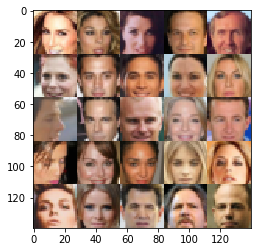

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeb_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

In [5]:
celeb_images.shape

(25, 28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/junji/miniconda3/envs/udacity-playground/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer 28 x 28 x channels
        
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # conv1 layer 14 x 14 x 64

        conv2 = tf.layers.conv2d(relu1, filters=128, kernel_size=3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=False)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # conv2 layer 7 x 7 x 128

        conv3 = tf.layers.conv2d(relu1, filters=256, kernel_size=3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=False)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # conv2 layer 4 x 4 x 256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*256)
        
        x1 = tf.reshape(x1, (-1, 3, 3, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3 x 3 x 256

        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=1)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 128

        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14 x 14 x 64

        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        # 28 x 28 x channel_dim
        
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_channels = 3 if data_image_mode == 'RGB' else 1
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps = 0
        samples = []
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, image_channels, is_train=False), feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 0.7627... Generator Loss: 1.1653
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 1.3055
Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 1.2622


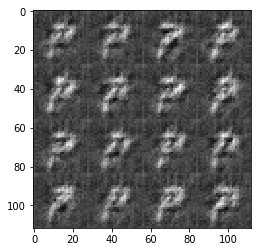

Epoch 1/2... Discriminator Loss: 0.6842... Generator Loss: 1.1863
Epoch 1/2... Discriminator Loss: 0.5821... Generator Loss: 1.5453
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 0.6470... Generator Loss: 1.4339
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 1.4219
Epoch 1/2... Discriminator Loss: 0.6629... Generator Loss: 1.2008
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 1.5144
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 1.5824
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 1.7619
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 1.4209


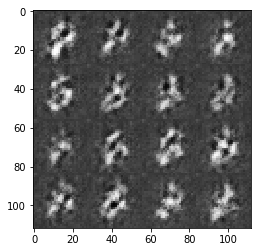

Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 1.6026
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 1.8632
Epoch 1/2... Discriminator Loss: 0.5822... Generator Loss: 1.3189
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 1.3635
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 1.6609
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 1.4496
Epoch 1/2... Discriminator Loss: 0.5663... Generator Loss: 1.5636
Epoch 1/2... Discriminator Loss: 0.5239... Generator Loss: 1.7299
Epoch 1/2... Discriminator Loss: 0.6015... Generator Loss: 1.4095
Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 1.5821


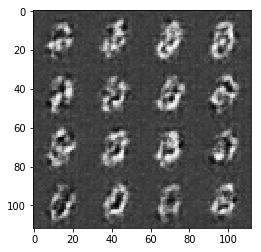

Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 1.8018
Epoch 1/2... Discriminator Loss: 0.4983... Generator Loss: 1.7883
Epoch 1/2... Discriminator Loss: 0.5192... Generator Loss: 1.5272
Epoch 1/2... Discriminator Loss: 0.6366... Generator Loss: 1.3917
Epoch 1/2... Discriminator Loss: 0.4876... Generator Loss: 1.5974
Epoch 1/2... Discriminator Loss: 0.4417... Generator Loss: 1.8750
Epoch 1/2... Discriminator Loss: 0.6121... Generator Loss: 1.7544
Epoch 1/2... Discriminator Loss: 0.4507... Generator Loss: 1.7989
Epoch 1/2... Discriminator Loss: 0.4845... Generator Loss: 1.6491
Epoch 1/2... Discriminator Loss: 0.4512... Generator Loss: 1.7802


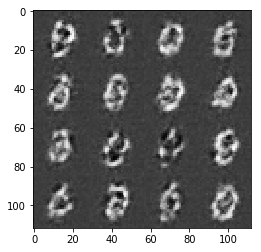

Epoch 1/2... Discriminator Loss: 0.4016... Generator Loss: 1.7851
Epoch 1/2... Discriminator Loss: 0.5133... Generator Loss: 1.7310
Epoch 1/2... Discriminator Loss: 0.3923... Generator Loss: 1.8029
Epoch 1/2... Discriminator Loss: 0.3719... Generator Loss: 1.9015
Epoch 1/2... Discriminator Loss: 0.4485... Generator Loss: 1.8774
Epoch 1/2... Discriminator Loss: 0.3839... Generator Loss: 1.9479
Epoch 2/2... Discriminator Loss: 0.4099... Generator Loss: 1.7549
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 1.6506
Epoch 2/2... Discriminator Loss: 0.3970... Generator Loss: 2.0612
Epoch 2/2... Discriminator Loss: 0.3501... Generator Loss: 2.1433


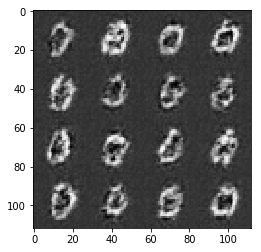

Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 2.1589
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 1.8835
Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 2.3276
Epoch 2/2... Discriminator Loss: 0.3309... Generator Loss: 2.0922
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 2.3270
Epoch 2/2... Discriminator Loss: 0.3073... Generator Loss: 2.0387
Epoch 2/2... Discriminator Loss: 0.3117... Generator Loss: 2.0947
Epoch 2/2... Discriminator Loss: 0.2822... Generator Loss: 2.2675
Epoch 2/2... Discriminator Loss: 0.2793... Generator Loss: 2.2175
Epoch 2/2... Discriminator Loss: 0.3461... Generator Loss: 2.0232


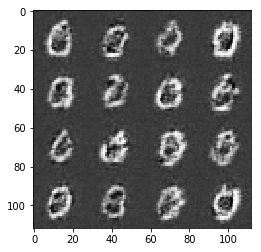

Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 1.9218
Epoch 2/2... Discriminator Loss: 0.3612... Generator Loss: 1.9804
Epoch 2/2... Discriminator Loss: 0.2895... Generator Loss: 2.3452
Epoch 2/2... Discriminator Loss: 0.2430... Generator Loss: 2.3465
Epoch 2/2... Discriminator Loss: 0.2780... Generator Loss: 2.3268
Epoch 2/2... Discriminator Loss: 0.5277... Generator Loss: 2.5458
Epoch 2/2... Discriminator Loss: 0.2406... Generator Loss: 2.3917
Epoch 2/2... Discriminator Loss: 0.2321... Generator Loss: 2.5278
Epoch 2/2... Discriminator Loss: 0.2486... Generator Loss: 2.3637
Epoch 2/2... Discriminator Loss: 0.4105... Generator Loss: 2.7011


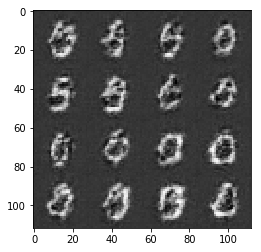

Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 1.9566
Epoch 2/2... Discriminator Loss: 0.2680... Generator Loss: 2.4518
Epoch 2/2... Discriminator Loss: 0.2493... Generator Loss: 2.4262
Epoch 2/2... Discriminator Loss: 0.2284... Generator Loss: 2.5263
Epoch 2/2... Discriminator Loss: 0.2608... Generator Loss: 2.3068
Epoch 2/2... Discriminator Loss: 0.2335... Generator Loss: 2.2517
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 2.8026
Epoch 2/2... Discriminator Loss: 0.2260... Generator Loss: 2.5430
Epoch 2/2... Discriminator Loss: 0.1967... Generator Loss: 2.5916
Epoch 2/2... Discriminator Loss: 0.2450... Generator Loss: 2.6790


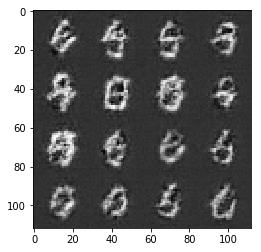

Epoch 2/2... Discriminator Loss: 0.2675... Generator Loss: 2.6158
Epoch 2/2... Discriminator Loss: 0.2234... Generator Loss: 2.5939
Epoch 2/2... Discriminator Loss: 0.2374... Generator Loss: 2.5303
Epoch 2/2... Discriminator Loss: 0.2122... Generator Loss: 2.6786
Epoch 2/2... Discriminator Loss: 0.5721... Generator Loss: 2.8762
Epoch 2/2... Discriminator Loss: 0.4270... Generator Loss: 2.6778
Epoch 2/2... Discriminator Loss: 0.2107... Generator Loss: 2.5992
Epoch 2/2... Discriminator Loss: 0.2132... Generator Loss: 2.7749
Epoch 2/2... Discriminator Loss: 0.2172... Generator Loss: 2.8397
Epoch 2/2... Discriminator Loss: 0.2271... Generator Loss: 2.3639


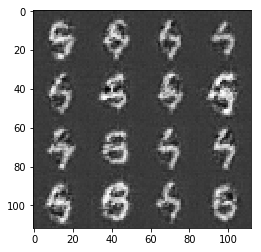

Epoch 2/2... Discriminator Loss: 0.2313... Generator Loss: 2.6995
Epoch 2/2... Discriminator Loss: 0.2044... Generator Loss: 2.5618
Epoch 2/2... Discriminator Loss: 0.3069... Generator Loss: 2.6484


In [45]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.4073
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 1.6016
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 2.7571
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 2.3381


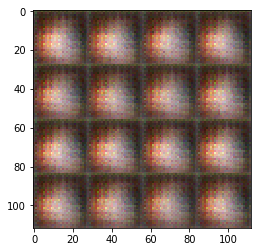

Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 1.7167
Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 2.1003
Epoch 1/1... Discriminator Loss: 0.2883... Generator Loss: 2.0492
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 2.5012
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 4.5797
Epoch 1/1... Discriminator Loss: 0.1220... Generator Loss: 6.3885
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 6.4687
Epoch 1/1... Discriminator Loss: 0.2263... Generator Loss: 2.8854
Epoch 1/1... Discriminator Loss: 0.1066... Generator Loss: 4.0672


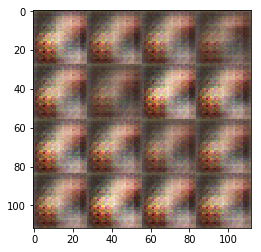

Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 1.9081
Epoch 1/1... Discriminator Loss: 0.2206... Generator Loss: 3.4842
Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 2.5782
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 3.5328
Epoch 1/1... Discriminator Loss: 0.1563... Generator Loss: 2.9008
Epoch 1/1... Discriminator Loss: 0.1633... Generator Loss: 2.8019
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 2.8080
Epoch 1/1... Discriminator Loss: 0.2151... Generator Loss: 2.9857
Epoch 1/1... Discriminator Loss: 0.1090... Generator Loss: 3.6767
Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 2.4741


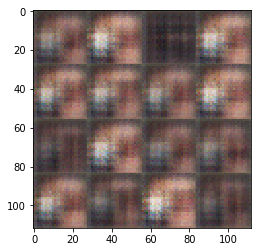

Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 3.6052
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 2.3306
Epoch 1/1... Discriminator Loss: 0.2503... Generator Loss: 2.1373
Epoch 1/1... Discriminator Loss: 0.3041... Generator Loss: 2.0399
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 2.6997
Epoch 1/1... Discriminator Loss: 0.1660... Generator Loss: 2.6650
Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 2.7657
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 2.6453
Epoch 1/1... Discriminator Loss: 0.2078... Generator Loss: 2.3633
Epoch 1/1... Discriminator Loss: 0.1508... Generator Loss: 3.2233


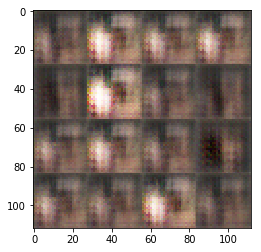

Epoch 1/1... Discriminator Loss: 0.1593... Generator Loss: 3.1258
Epoch 1/1... Discriminator Loss: 0.1365... Generator Loss: 3.1388
Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 3.0726
Epoch 1/1... Discriminator Loss: 0.1383... Generator Loss: 3.0956
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 2.7282
Epoch 1/1... Discriminator Loss: 0.1482... Generator Loss: 3.6609
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 2.7963
Epoch 1/1... Discriminator Loss: 0.1631... Generator Loss: 2.5509
Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 2.4082
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 3.1764


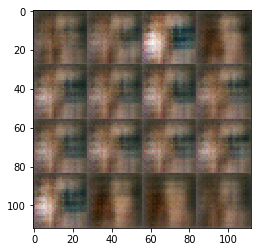

Epoch 1/1... Discriminator Loss: 0.0947... Generator Loss: 3.7049
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 2.7832
Epoch 1/1... Discriminator Loss: 0.1518... Generator Loss: 2.8992
Epoch 1/1... Discriminator Loss: 0.1364... Generator Loss: 2.8343
Epoch 1/1... Discriminator Loss: 0.1260... Generator Loss: 3.7840
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 2.5333
Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 2.8525
Epoch 1/1... Discriminator Loss: 0.1755... Generator Loss: 2.6148
Epoch 1/1... Discriminator Loss: 0.1460... Generator Loss: 3.3842
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 3.9827


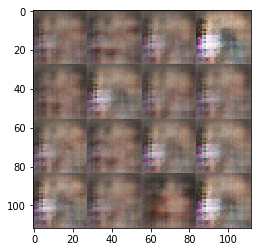

Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 2.9031
Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 3.4766
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 2.2529
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 3.5779
Epoch 1/1... Discriminator Loss: 0.1437... Generator Loss: 3.0157
Epoch 1/1... Discriminator Loss: 0.1506... Generator Loss: 4.0089
Epoch 1/1... Discriminator Loss: 0.1529... Generator Loss: 3.0505
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 2.7616
Epoch 1/1... Discriminator Loss: 0.1576... Generator Loss: 3.2872
Epoch 1/1... Discriminator Loss: 0.2132... Generator Loss: 2.2472


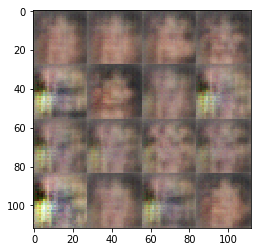

Epoch 1/1... Discriminator Loss: 0.1444... Generator Loss: 3.1069
Epoch 1/1... Discriminator Loss: 0.1288... Generator Loss: 3.4492
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 3.0259
Epoch 1/1... Discriminator Loss: 0.1970... Generator Loss: 2.3907
Epoch 1/1... Discriminator Loss: 0.2385... Generator Loss: 2.1246
Epoch 1/1... Discriminator Loss: 0.2099... Generator Loss: 2.9624
Epoch 1/1... Discriminator Loss: 0.2083... Generator Loss: 2.5431
Epoch 1/1... Discriminator Loss: 0.2052... Generator Loss: 2.2661
Epoch 1/1... Discriminator Loss: 0.1634... Generator Loss: 2.8730
Epoch 1/1... Discriminator Loss: 0.2265... Generator Loss: 3.1669


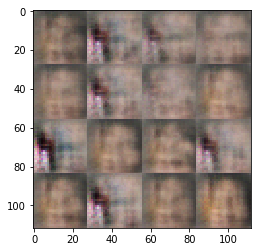

Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 2.6781
Epoch 1/1... Discriminator Loss: 0.2762... Generator Loss: 1.8602
Epoch 1/1... Discriminator Loss: 0.1763... Generator Loss: 2.7829
Epoch 1/1... Discriminator Loss: 0.1568... Generator Loss: 3.1852
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 3.2008
Epoch 1/1... Discriminator Loss: 0.2697... Generator Loss: 2.8793
Epoch 1/1... Discriminator Loss: 0.3187... Generator Loss: 1.7776
Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 2.8180
Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 4.2756


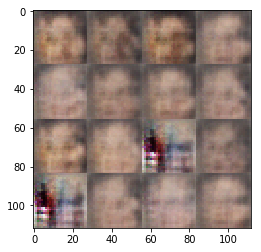

Epoch 1/1... Discriminator Loss: 0.2758... Generator Loss: 1.9075
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 3.9419
Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 2.4627
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 2.9896
Epoch 1/1... Discriminator Loss: 0.1967... Generator Loss: 2.8875
Epoch 1/1... Discriminator Loss: 0.1273... Generator Loss: 4.5157
Epoch 1/1... Discriminator Loss: 0.1222... Generator Loss: 3.8364
Epoch 1/1... Discriminator Loss: 0.1789... Generator Loss: 2.6406
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 3.0582
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 1.8570


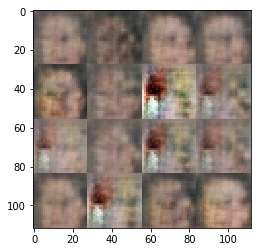

Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 2.6375
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 2.5220
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 2.5564
Epoch 1/1... Discriminator Loss: 0.1558... Generator Loss: 3.3072
Epoch 1/1... Discriminator Loss: 0.2059... Generator Loss: 2.4793
Epoch 1/1... Discriminator Loss: 0.2166... Generator Loss: 2.7368
Epoch 1/1... Discriminator Loss: 0.1364... Generator Loss: 4.3350
Epoch 1/1... Discriminator Loss: 0.1550... Generator Loss: 3.3691
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 3.5138
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.6232


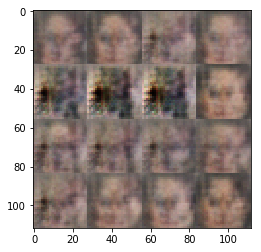

Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 1.8914
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 2.2823
Epoch 1/1... Discriminator Loss: 0.2808... Generator Loss: 2.2130
Epoch 1/1... Discriminator Loss: 0.2815... Generator Loss: 2.4746
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 2.5100
Epoch 1/1... Discriminator Loss: 0.2577... Generator Loss: 2.5123
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 2.1255
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 2.1399
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 2.2825


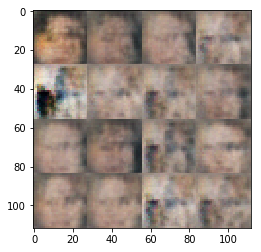

Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 1.8315
Epoch 1/1... Discriminator Loss: 0.2724... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 2.0578
Epoch 1/1... Discriminator Loss: 0.2762... Generator Loss: 2.1801
Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 2.6329
Epoch 1/1... Discriminator Loss: 0.2688... Generator Loss: 2.5874
Epoch 1/1... Discriminator Loss: 0.3081... Generator Loss: 2.0829
Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 2.1670
Epoch 1/1... Discriminator Loss: 0.2790... Generator Loss: 3.0436
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 5.2767


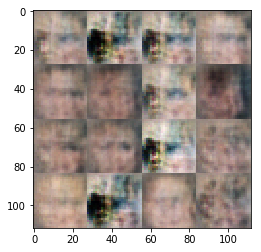

Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 2.0653
Epoch 1/1... Discriminator Loss: 0.2966... Generator Loss: 2.5194
Epoch 1/1... Discriminator Loss: 0.2963... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 0.2813... Generator Loss: 2.4146
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 1.9703
Epoch 1/1... Discriminator Loss: 0.2811... Generator Loss: 2.7386
Epoch 1/1... Discriminator Loss: 0.3145... Generator Loss: 2.3631
Epoch 1/1... Discriminator Loss: 0.3070... Generator Loss: 2.5321
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 2.5708
Epoch 1/1... Discriminator Loss: 0.1735... Generator Loss: 3.7701


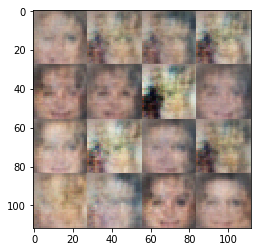

Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 3.3058
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 2.4960
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 2.4178
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 2.2717
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 1.7636
Epoch 1/1... Discriminator Loss: 0.2971... Generator Loss: 4.2095
Epoch 1/1... Discriminator Loss: 0.2115... Generator Loss: 2.4200


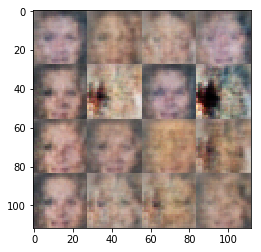

Epoch 1/1... Discriminator Loss: 0.2360... Generator Loss: 2.9364
Epoch 1/1... Discriminator Loss: 0.2250... Generator Loss: 2.8153
Epoch 1/1... Discriminator Loss: 0.2399... Generator Loss: 3.6318
Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 3.0845
Epoch 1/1... Discriminator Loss: 0.2952... Generator Loss: 2.0870
Epoch 1/1... Discriminator Loss: 0.2004... Generator Loss: 3.6089
Epoch 1/1... Discriminator Loss: 0.2067... Generator Loss: 3.7790
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 5.5993


In [46]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.